In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bikewheelcalc import BicycleWheel, Hub, Rim, ModeMatrix

import seaborn as sns

sns.set()

C:\Users\mateo\AppData\Local\conda\conda\envs\sandbox\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [8]:
wheel = BicycleWheel()
wheel.hub = Hub(diameter=0.050, width=0.050)
wheel.rim = Rim(radius=0.3, area=100e-6,
                I_lat=220./69e9, I_rad=110./69e9, J_tor=25./26e9, I_warp=0.0,
                young_mod=69e9, shear_mod=26e9)

wheel.lace_cross(n_spokes=36, n_cross=3, diameter=2.0e-3, young_mod=210e9, offset=0.)
wheel.apply_tension(80*9.81)  # about 80 kgf

mm = ModeMatrix(wheel, N=len(wheel.spokes))

K = mm.K_rim() + mm.K_spk(smeared_spokes=True)
K_inv = np.linalg.inv(K)
A = mm.A_adj()

theta_s = np.array([s.rim_pt[1] for s in wheel.spokes])

R_u = mm.B_theta(theta_s, comps=[0]).dot(K_inv.dot(A))
R_v = mm.B_theta(theta_s, comps=[1]).dot(K_inv.dot(A))
R_w = mm.B_theta(theta_s, comps=[2]).dot(K_inv.dot(A))

R_T = np.zeros((len(wheel.spokes), len(wheel.spokes)))
I_n = np.eye(len(wheel.spokes))
for i in range(len(wheel.spokes)):

    # Solve for wheel deformation
    dm = K_inv.dot(A[:, i])
    
    # Get tension changes, and put in the ith column of R_T
    R_T[:, i] = mm.spoke_tension_change(dm, a=I_n[:, i])

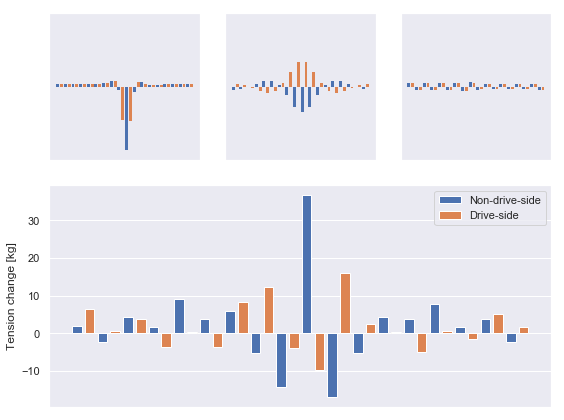

In [21]:
a = np.zeros(len(wheel.spokes))
a[int(len(wheel.spokes)/2)] = 0.0254/56.
s0 = wheel.spokes[0]
u_s = R_u.dot(a)
v_s = R_v.dot(a)
w_s = R_w.dot(a)

dT_u = [s.calc_tension_change((u_s[i], 0., 0., 0.))/9.81
        for i, s in enumerate(wheel.spokes)]
dT_v = [s.calc_tension_change((0., v_s[i], 0., 0.))/9.81
        for i, s in enumerate(wheel.spokes)]
dT_w = [s.calc_tension_change((0., 0., w_s[i], 0.))/9.81
        for i, s in enumerate(wheel.spokes)]

dT = R_T.dot(a) / 9.81


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8., 6.), sharey=True,
                       gridspec_kw = {'height_ratios':[2, 3]})

# ax[0].bar(np.arange(len(wheel.spokes)), s0.EA/s0.length*a/9.8, width=0.75)

ax[0, 0].bar(np.arange(0, len(wheel.spokes), 2), dT_v[0::2], width=0.75, color='C0', edgecolor='none')
ax[0, 0].bar(np.arange(1, len(wheel.spokes), 2), dT_v[1::2], width=0.75, color='C1', edgecolor='none')

ax[0, 1].bar(np.arange(0, len(wheel.spokes), 2), dT_u[0::2], width=0.75, color='C0', edgecolor='none')
ax[0, 1].bar(np.arange(1, len(wheel.spokes), 2), dT_u[1::2], width=0.75, color='C1', edgecolor='none')

ax[0, 2].bar(np.arange(0, len(wheel.spokes), 2), dT_w[0::2], width=0.75, color='C0', edgecolor='none')
ax[0, 2].bar(np.arange(1, len(wheel.spokes), 2), dT_w[1::2], width=0.75, color='C1', edgecolor='none')

gs = ax[1, 2].get_gridspec()

for a in ax[1, :]:
    a.remove()

ax_T = fig.add_subplot(gs[1, :])

ax_T.set_ylabel('Tension change [kg]')
ax_T.bar(np.arange(0, len(wheel.spokes), 2), dT[0::2], width=0.75, color='C0', label='Non-drive-side')
ax_T.bar(np.arange(1, len(wheel.spokes), 2), dT[1::2], width=0.75, color='C1', label='Drive-side')

ax_T.legend()

for a in ax[0, :]:
    a.set_xticks([])
    a.set_yticks([])
    
ax_T.set_xticks([])

ax[0, 0].set_ylim([-55, 55])

plt.tight_layout()
plt.savefig('../../content/images/wheel-truing/tension-components.png')

In [64]:
height = 60

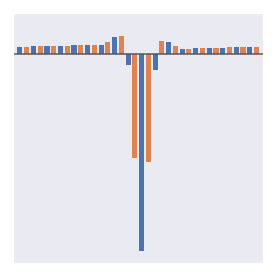

In [70]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.bar(np.arange(0, len(wheel.spokes), 2), dT_v[0::2], width=0.75, color='C0', edgecolor='none')
ax.bar(np.arange(1, len(wheel.spokes), 2), dT_v[1::2], width=0.75, color='C1', edgecolor='none')

y_center = -20
ax.plot([-5, 40], [0, 0], '#555555')
ax.set_ylim([y_center-height/2, y_center+height/2])
ax.set_xlim(-1, 36)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../../content/images/wheel-truing/tension-components-v.png')

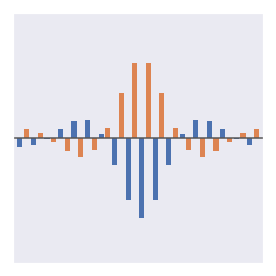

In [71]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.bar(np.arange(0, len(wheel.spokes), 2), dT_u[0::2], width=0.75, color='C0', edgecolor='none')
ax.bar(np.arange(1, len(wheel.spokes), 2), dT_u[1::2], width=0.75, color='C1', edgecolor='none')

y_center = 0
ax.plot([-5, 40], [0, 0], '#555555')
ax.set_ylim([y_center-height/2, y_center+height/2])
ax.set_xlim(-1, 36)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../../content/images/wheel-truing/tension-components-u.png')

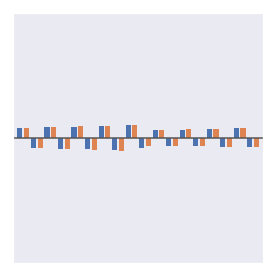

In [72]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.bar(np.arange(0, len(wheel.spokes), 2), dT_w[0::2], width=0.75, color='C0', edgecolor='none')
ax.bar(np.arange(1, len(wheel.spokes), 2), dT_w[1::2], width=0.75, color='C1', edgecolor='none')

y_center = 0
ax.plot([-5, 40], [0, 0], '#555555')
ax.set_ylim([y_center-height/2, y_center+height/2])
ax.set_xlim(-1, 36)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../../content/images/wheel-truing/tension-components-w.png')

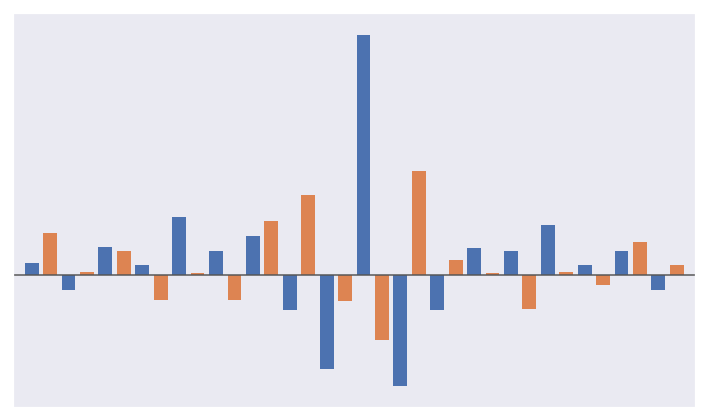

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(np.arange(0, len(wheel.spokes), 2), dT[0::2], width=0.75, color='C0', edgecolor='none')
ax.bar(np.arange(1, len(wheel.spokes), 2), dT[1::2], width=0.75, color='C1', edgecolor='none')

ax.plot([-5, 40], [0, 0], '#555555')
ax.set_ylim([-20, 40])
ax.set_xlim(-1, 36)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../../content/images/wheel-truing/tension-components-total.png')

## Plot influence function for a certain adjustment

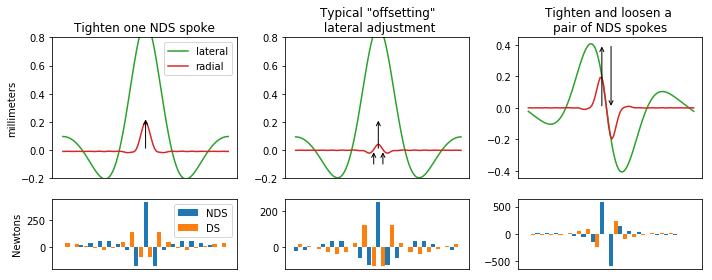

In [5]:
def plot_inf_fxn(c, a):
    
    d = np.linalg.solve(K, A.dot(a))

    theta = np.linspace(0, 2*np.pi, 100)
    u = mm.B_theta(theta, comps=[0]).dot(d)
    v = mm.B_theta(theta, comps=[1]).dot(d)

    ax[0, c].plot(theta, 1000.*u, 'C2', label='lateral')
    ax[0, c].plot(theta, 1000.*v, 'C3', label='radial')
    ax[0, c].set_xticklabels([])
    
    for i in np.flatnonzero(a):
        arrow_dir = (2*(wheel.spokes[i].hub_pt[2] > 0)-1)
#         arrow_mag = 0.9*56./0.0254*np.abs(a[i])*0.4
        arrow_mag = 0.9*(np.abs(a[i])/np.max(np.abs(a))*
                         np.min(np.abs(ax[0, c].get_ylim())))
        if a[i] > 0:  # tighten
            ax[0, c].annotate("",
                              xy=(theta_s[i], arrow_dir*arrow_mag),
                              xytext=(theta_s[i], 0.),
                              arrowprops={'arrowstyle': "->"})
        else:
            ax[0, c].annotate("",
                              xytext=(theta_s[i], arrow_dir*arrow_mag),
                              xy=(theta_s[i], 0.),
                              arrowprops={'arrowstyle': "->"})

    ax[1, c].bar(theta_s[::2], R_T.dot(a)[::2], width=0.9*2*np.pi/36.,
              color='C0', label='NDS')
    ax[1, c].bar(theta_s[1::2], R_T.dot(a)[1::2], width=0.9*2*np.pi/36.,
              color='C1', label='DS')
    
    ax[0, c].set_xticks([])
    ax[1, c].set_xticks([])

    
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4),
                       sharex=True,
                       gridspec_kw = {'height_ratios':[2, 1]})

# Tighten a single spoke
a = np.zeros(36)
a[18] = 0.0254 / 56.   # Tighten one full turn
plot_inf_fxn(0, a)
ax[0, 0].set_ylim([-0.2, 0.8])

# Typical "off-setting" lateral adjustment
a = np.zeros(36)
a[18] = 0.0254 / 56. / 2.   # Tighten one full turn
a[17] = -0.0254 / 56. / 4.  # Loosen one half turn
a[19] = -0.0254 / 56. / 4.  # Loosen one half turn
plot_inf_fxn(1, a)
ax[0, 1].set_ylim([-0.2, 0.8])

# Tighten and loosen two adjacent spokes on the same side
a = np.zeros(36)
a[16] = 0.0254 / 56.   # Tighten one full turn
a[18] = -0.0254 / 56.  # Loosen one full turn
plot_inf_fxn(2, a)

    
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel('millimeters')
ax[1, 0].set_ylabel('Newtons')

ax[0, 0].set_title('Tighten one NDS spoke')
ax[0, 1].set_title('Typical "offsetting"\n lateral adjustment')
ax[0, 2].set_title('Tighten and loosen a \npair of NDS spokes')

plt.tight_layout();